# Simulation of Prosumers in a Net-Metered Market with a Utility

## Description:
Prosumers are collected as a model with the consumption, generation, net energy and pricing data avaialble.

## Steps:
### 1. Data Gathering 
    - Shows the steps taken to acquire the data from EIA.gov
    - Validation of collected data with other resources , ie. NREL

### 2. Data Cleansing
    - Conversion of units, normalization and joing of datasets
    
### 3. Build Model from Data
    - Implement statistical variations to curves
    - Create individual prosumer models and save to csv file

# Net-Metering for a Network of Prosumers

**What is Net-Metering?**
[Net metering](https://en.wikipedia.org/wiki/Net_metering) is an electricity billing mechanism that allows consumers who generate some or all of their own electricity to use that electricity anytime, instead of when it is generated. This is particularly important with renewable energy sources like wind and solar, which are non-dispatchable. 

We can define the payment for a prosumer in the state of Florida by the retail pricing provided to the prosumer for every kWh that is injected back into the Grid. 

In [8]:
def get_net_meter_payment(price,net_energy):
    # convert to dollars from cents
    return abs(net_energy)*(0.01*price)

Lets define a large (100+) number of prosumers in the FPL territory and consider the net-metering profits the prosumers could make during the course of a year. We will also use the same assumptions made to the average consumption and average generation of a typical prosumer in the area. These assumptions can be adjusted if the capacity and usage of each home is known. The prosumer class will be modified to support generating the profit for each month given the price curve.

In [13]:
# Generate a collection of prosumers
N = 100 # Number of prosumers to create
prosumers = get_prosumers(N, 
                    gen_args= {
                    'type':'generation',
                    'mean':1200,
                    'std': 1200 * 0.2, #20% of mean,
                    'ulim':1200, # upper limit (capacity),
                    'llim':0 # lower limit
                    },gen_df=generation.df, 
                    dem_args= {   
                    'type':'demand',
                    'mean':1100,
                    'std': 1100 * 0.2, #20% of mean
                    'ulim':1100 * 2, # upper limit (max load),
                    'llim':1100 * 0.1 # lower limit (constant load) 
                    },dem_df=demand.df)
#set the price
for prosumer in prosumers:
    prosumer.set_price(price_df=price.df,method=get_net_meter_payment)


NameError: name 'get_prosumers' is not defined

Analyze the average profit for all prosumers

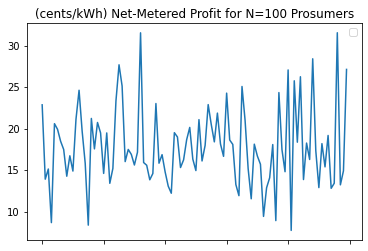

In [18]:
#show pricing for all prosumers
get_curve_accross_prosumers('profit').mean().plot(x='time',title=f"(cents/kWh) Net-Metered Profit for N={len(prosumers)} Prosumers")
plt.legend('')
plt.show()

We will also modify the Prosumer object to include the 

In [10]:
def get_totals_accross_prosumers(type_name):
    prosumers_arr = []
    for prosumer in prosumers:
        prosumers_arr.append(
            pd.DataFrame(list(zip(prosumer.data['time'],prosumer.data[type_name])),columns=['time',f'Prosumer:{prosumer.id}']))
    return reduce(lambda left,right: pd.merge(left,right,on=['time'],how='outer'), prosumers_arr)



In [11]:
sheet = []
total_net_meter_profit = 0
total_nrg_meter_profit =0
total_net_enrgy=0
for prosumer in prosumers:
    sheet.append(
        {
            'Prosumer':prosumer['id'],
            'Total Net-Metering Profit ($)':prosumer['data']['net_meter'].sum(),
            'Total NRG X-Change Profit ($)':prosumer['data']['nrg_meter'].sum(),
            'Total Net Energy (kWh)':prosumer['data']['net_energy'].sum()
        }
    )
    total_net_meter_profit += prosumer['data']['net_meter'].sum()
    total_nrg_meter_profit += prosumer['data']['nrg_meter'].sum()
    total_net_enrgy += prosumer['data']['net_energy'].sum()
    prosumer['data'].plot(x='time',y=['net_meter'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")

print(tabulate(sheet, headers = 'keys', tablefmt = 'github',showindex=False)) 
print(tabulate([{'Prosumer':'All',
            'Total Net-Metering Profit ($)':total_net_meter_profit,
            'Total NRG X-Change Profit ($)':total_nrg_meter_profit,
            'Total Net Energy (kWh)':total_net_enrgy}],headers = 'keys', tablefmt = 'github',showindex=False)) 

NameError: name 'prosumers' is not defined

In [ ]:
def get_net_meter_payment(price,net_energy):
    # convert to dollars from cents
    return net_energy*(0.01*price)


In [ ]:

def get_nrg_xchange_payment(price,net_energy,total_net_energy,a,n):
    tx = total_net_energy
    payments = []
    for i in range(len(net_energy)):
        x = net_energy[i]
        q = (0.01*price[i])
        try:
            ans = (pow(x,n)*q)/math.exp(pow(tx,2)/a)
        except OverflowError:
            ans = float('inf')
        payments.append(ans)
    return payments

# Create the net metering profit from net energy    
total_net_energy = sum([p['data']['net_energy'].sum() for p in prosumers])
for prosumer in prosumers:
    df_prosumer = prosumer['data']    
    nrg = get_nrg_xchange_payment(net_energy=df_prosumer['net_energy'],price=df_prosumer['price'],total_net_energy=total_net_energy,a=10000000,n=1)
    time_n_nrg = list(zip(df_prosumer['time'],nrg))
    df_nrg = pd.DataFrame(time_n_nrg,columns=['time','nrg_meter'])
    prosumer['data'] = df_prosumer.merge(df_nrg,on='time')


In [ ]:
#plot the prosumers
for prosumer in prosumers:
    print(f"\nProsumer:{prosumer['id']}")
    print(tabulate(prosumer['data'], headers = 'keys', tablefmt = 'github',showindex=False))
    prosumer['data'].plot(x='time',y=['demand','generation','net_energy'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")
    

# Step 4 : Analyze Results for Net-Metering Profit

Determine the results of the prosumers 

In [12]:
sheet = []
total_net_meter_profit = 0
total_nrg_meter_profit =0
total_net_enrgy=0
for prosumer in prosumers:
    sheet.append(
        {
            'Prosumer':prosumer['id'],
            'Total Net-Metering Profit ($)':prosumer['data']['net_meter'].sum(),
            'Total NRG X-Change Profit ($)':prosumer['data']['nrg_meter'].sum(),
            'Total Net Energy (kWh)':prosumer['data']['net_energy'].sum()
        }
    )
    total_net_meter_profit += prosumer['data']['net_meter'].sum()
    total_nrg_meter_profit += prosumer['data']['nrg_meter'].sum()
    total_net_enrgy += prosumer['data']['net_energy'].sum()
    prosumer['data'].plot(x='time',y=['net_meter'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")

print(tabulate(sheet, headers = 'keys', tablefmt = 'github',showindex=False)) 
print(tabulate([{'Prosumer':'All',
            'Total Net-Metering Profit ($)':total_net_meter_profit,
            'Total NRG X-Change Profit ($)':total_nrg_meter_profit,
            'Total Net Energy (kWh)':total_net_enrgy}],headers = 'keys', tablefmt = 'github',showindex=False)) 


NameError: name 'prosumers' is not defined

# Run Experiment for a Large Network of Prosumers

In [ ]:
# Generate a collection of prosumers
N = 100 # Number of prosumers to create

# set some constants for the build
init = [
        {
            'type':'generation',
            'mean':1200,
            'std': 1200 * 0.2, #20% of mean,
            'ulim':1200, # upper limit (capacity),
            'llim':0 # lower limit 
        },
        {   
            'type':'demand',
            'mean':1100,
            'std': 1100 * 0.2, #20% of mean
            'ulim':1100 * 2, # upper limit (max load),
            'llim':1100 * 0.1 # lower limit (constant load) 
        } 
    ]

## NRG-X-Change requires a Scaler Adjustment for Larger Network

In [ ]:
prosumers = []
for n in range(N):
    pro_datasets = []
    # Create a price column
    pro_datasets.append(df[['time','price']])
    # Create the generation and demand columns    
    for conf in init:
        curve = df[conf['type']]
        c = [max(conf['llim'],min(conf['ulim'],
        random.normal(loc=conf['mean'],scale=conf['std'])*x)) for x in curve]
        df_t = pd.DataFrame(list(zip(df['time'],c)),columns=['time',conf['type']])
        pro_datasets.append(df_t)
     # merge the datasets
    df_p = reduce(lambda  left,right: pd.merge(left,right,on=['time'],how='outer'), pro_datasets)

    # Add net energy from demand and generation cols
    net_energy = df_p['demand'] - df_p['generation']
    net_energy_cap = [max(x,0) for x in net_energy]
    time_n_net_energy = list(zip(df['time'],net_energy_cap))
    df_net = pd.DataFrame(time_n_net_energy,columns=['time','net_energy'])
    df_pn = df_p.merge(df_net,on='time')

    # Create the net metering profit from net energy
    net_meter = get_net_meter_payment(net_energy=df_pn['net_energy'],price=df_pn['price'])
    time_n_net_meter = list(zip(df['time'],net_meter))
    df_net_met = pd.DataFrame(time_n_net_meter,columns=['time','net_meter'])
    df_m = df_pn.merge(df_net_met,on='time')

    # add prosumer to group
    prosumers.append({"id":n+1,"data":df_m})

# Create the net metering profit from net energy    
total_net_energy = sum([p['data']['net_energy'].sum() for p in prosumers])
for prosumer in prosumers:
    df_prosumer = prosumer['data']    
    nrg = get_nrg_xchange_payment(net_energy=df_prosumer['net_energy'],price=df_prosumer['price'],total_net_energy=total_net_energy,a=100000000000,n=1) #as the number of participants grows the scale value has to increase
    time_n_nrg = list(zip(df_prosumer['time'],nrg))
    df_nrg = pd.DataFrame(time_n_nrg,columns=['time','nrg_meter'])
    prosumer['data'] = df_prosumer.merge(df_nrg,on='time')

In [ ]:

#for prosumer in prosumers:
 #   print(f"\nProsumer:{prosumer['id']}")
  #  print(tabulate(prosumer['data'], headers = 'keys', tablefmt = 'github',showindex=False))
    

In [ ]:
sheet = []
total_net_meter_profit = 0
for prosumer in prosumers:
    sheet.append(
        {
            'Prosumer':prosumer['id'],
            'Total Net-Metering Profit ($)':prosumer['data']['net_meter'].sum(),
            'Total NRG X-Change Profit ($)':prosumer['data']['nrg_meter'].sum(),
            'Total Net Energy (kWh)':prosumer['data']['net_energy'].sum()
        }
    )
    total_net_meter_profit += prosumer['data']['net_meter'].sum()
    total_nrg_meter_profit += prosumer['data']['nrg_meter'].sum()
    total_net_enrgy += prosumer['data']['net_energy'].sum()
    
print(tabulate(sheet, headers = 'keys', tablefmt = 'github',showindex=False)) 
print(tabulate(
        [{   'Prosumer':'All',
            'Total Net-Metering Profit ($)':total_net_meter_profit,
            'Total NRG X-Change Profit ($)':total_nrg_meter_profit,
            'Total Net Energy (kWh)':total_net_enrgy
        }],headers = 'keys', tablefmt = 'github',showindex=False)) 

# NRG-X-Change is Not Effective as Linear Function, Why?


1. The simulation should adjust the *a* scalar and reduce the network from N to just the ones who contributed, allowing for a redistribution of profit at higher levels for just those who contributed instead accross the whole of N.



1. Validate the dataset
2. Use 12 monhts 
4. Multiple years?
3. Remove restriction for he generation how much better can i have?
3. Fix graphs with details
5. Setup 100 prosumers as Shapley coalition
    - what would be the payment
6. THe function needs to be modified to include conusmption? but how?
- The max payout is when the total productiona and consumption are equal..
- the consumption of the prosumers and hte net metering is seprate. 